In [19]:
import tensorflow as tf
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.neighbors import KDTree
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsClassifier
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import operator
import scipy as sp
from sklearn import preprocessing
import json
import pandas as pd
from scipy.stats import gamma
from math import log2
from scipy.optimize import curve_fit


In [3]:
data_location_AT = ["/content/drive/MyDrive/DistanceClassifier/data/ATER",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATERDD",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATGEO",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATGEOGD",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATHGG",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATSF",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATSFDD",
                 "/content/drive/MyDrive/DistanceClassifier/data/ATSticky"]

AT_original = "/content/drive/MyDrive/DistanceClassifier/data/ATOriginal"

In [67]:
data_dict = {}
for network in data_location_AT:
  df = pd.read_csv(network, sep = ' ', header = None)
  data_dict[network[47:]] = df

In [69]:
data_dict['ATER']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,35223.0,258905.0,64.0,1901966.0,631093.0,359.0,1438.0,0.0,0.0,13957063.0,6950121.5,1149374.0,10613.0,10701.0,5247.0,2156.0,10588.0,0.0,1.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34927.0,255662.0,56.0,1869481.0,623275.0,398.0,1283.0,0.0,0.0,13647797.0,6828568.0,1138929.0,9912.0,9594.0,4900.0,2022.0,11419.0,0.0,3.0,0.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34967.0,256552.0,65.0,1882504.0,626561.0,351.0,1441.0,0.0,0.0,13798744.0,6894799.5,1143167.0,10573.0,10701.0,5330.0,2106.0,10335.0,0.0,2.0,0.0,2.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35012.0,258223.0,66.0,1903187.0,637004.0,382.0,1427.0,0.0,0.0,14015135.0,7038376.5,1182312.0,10281.0,10611.0,5175.0,2166.0,11347.0,0.0,0.0,0.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35021.0,256701.0,69.0,1878882.0,626033.0,335.0,1518.0,0.0,0.0,13743441.0,6860245.5,1142749.0,11097.0,11097.0,5484.0,2100.0,9679.0,0.0,4.0,0.0,1.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,34762.0,253364.0,63.0,1843691.0,614887.0,359.0,1393.0,0.0,0.0,13397586.0,6700534.0,1117743.0,10070.0,10034.0,5141.0,2069.0,10319.0,0.0,3.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
495,34843.0,255226.0,62.0,1869917.0,624515.0,330.0,1418.0,2.0,0.0,13690197.0,6862871.0,1147650.0,10770.0,10270.0,5411.0,2106.0,9635.0,21.0,4.0,26.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,35494.0,264069.0,64.0,1962833.0,654049.0,375.0,1444.0,0.0,0.0,14577567.0,7285247.5,1212266.0,10921.0,10682.0,5375.0,2288.0,11005.0,0.0,3.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,34852.0,255494.0,69.0,1869813.0,624419.0,378.0,1491.0,0.0,0.0,13672726.0,6845517.0,1141112.0,10599.0,10930.0,5386.0,2087.0,11126.0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
#euclidean distance formula
def euclid(origin, other):
  return np.sum((origin - other) ** 2)**(1/2)

#find euclidean distances between all points and return it as an array
#takes a row and finds euclidean distance between this row and every other row in the dataframe
#(skips itself; if distance with itself will be 0)
def find_distances(df_vals):
  euclid_list = []
  for reference_row in df_vals:
    reference_dists = []
    for other_row in df_vals:
      euclid_dist = euclid(reference_row, other_row)
      if euclid_dist == 0:
        continue
      else:
        reference_dists.append(euclid_dist)
    euclid_list.append(reference_dists)
  return euclid_list

#finds the smallest num in the array of arrays
def smallest_in_arr(euclid_list):
  small_arr = []
  smallest = 99;
  for array in euclid_list:
    small_arr.append(min(array))
  return small_arr

#pipeline the functions together
def NearNeigh_pipeline(df):
  df_vals = df.values
  euclid_dists = find_distances(df_vals)
  euclid_dists = np.asarray(euclid_dists)
  return np.asarray(smallest_in_arr(euclid_dists))

In [71]:
#find the nearest distances of the networks
nearest_dict = {}
for network in data_location_AT:
  name = network[47:] #need to splice path to get name
  nearest = NearNeigh_pipeline(data_dict[name])
  nearest_dict[name] = nearest

In [84]:
#print the last element to check if it worked
nearest_dict['ATER'][498]

252364.0142769963

# Everything below is from Shiqi's notebook

In [73]:
def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))    
    return m

In [74]:
def plot_empirical_CDF(data, Density):
    f, ax = plt.subplots(1,1,figsize=(8,6))
    h = ax.hist(data,bins=499,density=Density,cumulative=True,histtype='stepfilled')    # bins set to equal to # of empirical data
    x = h[1][:-1]
    y = h[0]
    ax.plot(x,y,color='k', label='Empirical')
    ax.legend()
    plt.show()
    return x,y

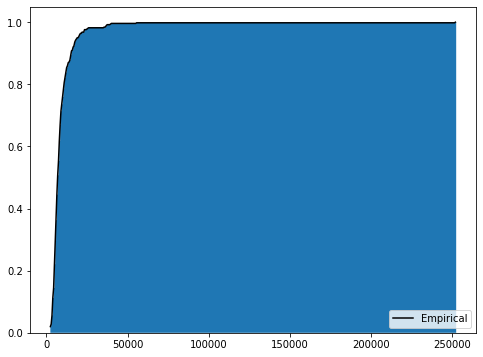

In [75]:
x, y = plot_empirical_CDF(nearest_dict['ATER'], Density = True)

[3.12146686e-02 2.89887641e+02]


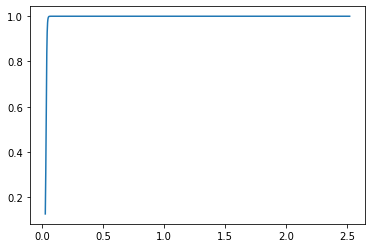

In [76]:
x = nearest_dict['ATER']
x.sort()
x = x/1e5
p0 = [np.median(x),1] # this is initial guess for curve_fit()

popt, pcov = curve_fit(f=logistic, xdata=x, ydata=y, p0=p0,method='lm')

# parameters yielded by Curve_fit: x0, k , b
print(popt)

y2 = logistic(x, *popt)
plt.plot(x,y2)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


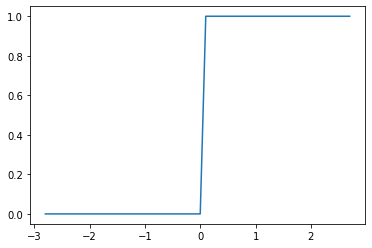

In [77]:
x3 = np.arange(-2.8,2.8,0.1)
y3 = logistic(x3,*popt)
plt.plot(x3,y3)
plt.show()

In [78]:
def plot_sigmoid(data,Density, func, param):
    f, ax = plt.subplots(1,1,figsize=(10,8))
    h = ax.hist(data,bins=499,density=Density,edgecolor='white',cumulative=True,histtype='step')
    x = h[1][:-1]
    y = h[0]

    y2 = func(x,*param)    # by func curve_fit
    ax.set_yscale('log')
    ax.plot(x[:-100],1-y[:-100],color='g',label='1-empirical')
    ax.scatter(x[:])
    ax.plot(x,1-y2,color='y',label='1-sigmoid')
    ax.legend(loc='upper left')
    plt.show()
    return x,y,y2

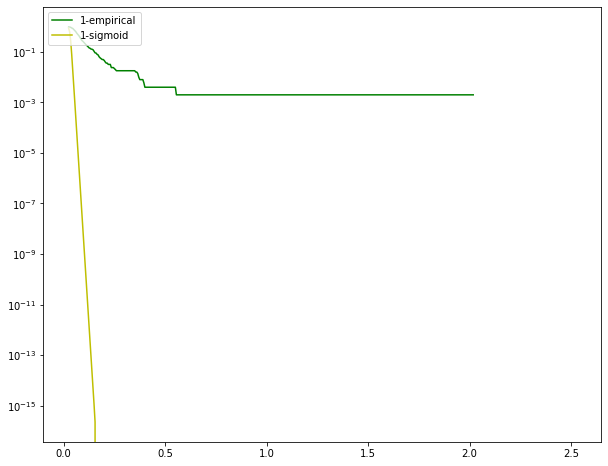

In [79]:
data = x
Density=True
func=logistic
param=popt

f, ax = plt.subplots(1,1,figsize=(10,8))
h = ax.hist(data,bins=499,density=Density,edgecolor='white',cumulative=True,histtype='step')
x = h[1][:-1]
y = h[0]

y2 = func(x,*param)    # by func curve_fit
ax.set_yscale('log')
ax.plot(x[:-100],1-y[:-100],color='g',label='1-empirical')
# ax.scatter(x[:])
ax.plot(x,1-y2,color='y',label='1-sigmoid')
ax.legend(loc='upper left')
plt.show()